# Dietní problém — lineární program od A do Z v Pythonu (PuLP)

**Cíl.** Minimalizovat cenu jedné porce přílohy v restauraci při splnění minimálních požadavků na vitamín A, vitamín C a vlákninu.

**Zdroj dat.** Zjednodušená tabulka se třemi potravinami:

- Mrkev (syrová)  
- Zelí (syrové)  
- Okurka (kyselá)  

**Jednotky:**
- Rozhodovací proměnné jsou **kilogramy na porci**.  
- Vitamín A a C jsou v **mg na kg** potraviny.  
- Vláknina je v **g na kg** potraviny.  
- Ceny jsou v **Kč za kg**.  

**Požadavky na porci**
- Vitamín A ≥ 0,5 mg  
- Vitamín C ≥ 15 mg  
- Vláknina ≥ 4 g  

**Co uděláme:**
1. Nahrajeme data.  
2. Sestavíme LP model.  
3. Vyřešíme v PuLP (CBC).  
4. Ověříme a interpretujeme řešení.  
5. Zobrazíme geometrii v 3D a izo-nákladové roviny.  
6. Provedeme základní i rozšířenou citlivostní analýzu.  



In [23]:
# Install and import libraries
!pip -q install pulp plotly pandas numpy matplotlib

import numpy as np
import pandas as pd
import plotly.graph_objects as go
import plotly.io as pio
import matplotlib.pyplot as plt
from itertools import combinations
import math
import pulp

pio.renderers.default = "colab"  # good default in Colab
pd.set_option("display.precision", 6)


# Data

Tabulka níže kóduje ceny a „hustoty živin“ jednotlivých potravin.

**Rozhodovací proměnné:**
- $x_{\text{carrot}}$ = kg syrové mrkve na porci  
- $x_{\text{cabbage}}$ = kg syrového zelí na porci  
- $x_{\text{cucumber}}$ = kg kyselé okurky na porci  

**Účelová funkce (minimalizace nákladů na porci):**

$$
\min \; 15x_{\text{carrot}} + 10x_{\text{cabbage}} + 3x_{\text{cucumber}}
$$

**Omezení** (vše ve tvaru $\ge$, protože minima musíme splnit nebo překročit):

$$
35x_{\text{carrot}} + 0.5x_{\text{cabbage}} + 0.5x_{\text{cucumber}} \geq 0.5 \quad \text{(vitamín A v mg)}
$$

$$
60x_{\text{carrot}} + 300x_{\text{cabbage}} + 10x_{\text{cucumber}} \geq 15 \quad \text{(vitamín C v mg)}
$$

$$
30x_{\text{carrot}} + 20x_{\text{cabbage}} + 10x_{\text{cucumber}} \geq 4 \quad \text{(vláknina v g)}
$$

$$
x_{\text{carrot}}, x_{\text{cabbage}}, x_{\text{cucumber}} \geq 0
$$

**Poznámka k interpretaci:**  
Každá rovnice popisuje nadrovinu v prostoru $(x_{\text{carrot}}, x_{\text{cabbage}}, x_{\text{cucumber}})$.  
Přípustná množina je průnik příslušných poloprostorů a nezáporného ortantu. Optimální řešení LP leží v některém z vrcholů (bázických řešení).


In [24]:
# Tabular data
foods = ["Carrot_raw", "Cabbage_raw", "Cucumber_pickled"]

data = pd.DataFrame({
    "price_KC_per_kg":            [15.0, 10.0, 3.0],
    "vitamin_A_mg_per_kg":        [35.0, 0.5, 0.5],
    "vitamin_C_mg_per_kg":        [60.0, 300.0, 10.0],
    "fiber_g_per_kg":             [30.0, 20.0, 10.0],
}, index=foods)

requirements = {
    "vitamin_A_mg": 0.5,
    "vitamin_C_mg": 15.0,
    "fiber_g":      4.0,
}

display(data.style.format(precision=3).set_caption("Food data (per kg)"))
pd.Series(requirements, name="Min per serving").to_frame()


Min per serving
vitamin_A_mg              0.5
vitamin_C_mg             15.0
fiber_g                   4.0

# Formulace a řešení

Vytvoříme jednu nezápornou proměnnou na potravinu, minimalizujeme celkové náklady a vynutíme tři živinová omezení.  
Následně zavoláme CBC solver (simplexová metoda) integrovaný v PuLP.


In [25]:
def solve_diet_pulp(data: pd.DataFrame, req: dict, msg=False):
    prob = pulp.LpProblem("Diet", pulp.LpMinimize)

    # Decision variables: kg per serving
    x = {f: pulp.LpVariable(f"x_{f}", lowBound=0) for f in data.index}

    # Objective
    prob += pulp.lpSum(data.loc[f, "price_KC_per_kg"] * x[f] for f in data.index)

    # Constraints
    prob += pulp.lpSum(data.loc[f, "vitamin_A_mg_per_kg"] * x[f] for f in data.index) >= req["vitamin_A_mg"], "vitamin_A"
    prob += pulp.lpSum(data.loc[f, "vitamin_C_mg_per_kg"] * x[f] for f in data.index) >= req["vitamin_C_mg"], "vitamin_C"
    prob += pulp.lpSum(data.loc[f, "fiber_g_per_kg"]      * x[f] for f in data.index) >= req["fiber_g"],      "fiber"

    # Solve (CBC bundled with PuLP)
    solver = pulp.PULP_CBC_CMD(msg=msg)
    status_code = prob.solve(solver)
    status = pulp.LpStatus[status_code]

    # Collect results
    x_kg = {f: v.value() for f, v in x.items()}
    x_g  = {f: 1000.0 * val for f, val in x_kg.items()}
    cost = pulp.value(prob.objective)

    # Nutrient totals
    totals = {
        "vitamin_A_mg": sum(data.loc[f, "vitamin_A_mg_per_kg"] * x_kg[f] for f in data.index),
        "vitamin_C_mg": sum(data.loc[f, "vitamin_C_mg_per_kg"] * x_kg[f] for f in data.index),
        "fiber_g":      sum(data.loc[f, "fiber_g_per_kg"]      * x_kg[f] for f in data.index),
    }
    slacks = {k: totals[k] - req[k] for k in req}

    return {
        "status": status,
        "x_kg": x_kg,
        "x_g": x_g,
        "cost": cost,
        "totals": totals,
        "slacks": slacks,
        "model": prob,
    }

res = solve_diet_pulp(data, requirements, msg=False)

print("Status:", res["status"])
print("Cost [Kč]:", round(res["cost"], 4))
pd.Series(res["x_g"], name="g per serving").to_frame()


Status: Optimal
Cost [Kč]: 1.4102


g per serving
Carrot_raw             9.526344
Cabbage_raw           38.265035
Cucumber_pickled     294.890900

# Interpretace

- Nahlásíme porci v gramech.  
- Zkontrolujeme, že každá dosažená živina splňuje své minimum.  
- Označíme vázaná omezení (slack ≈ 0), tj. ta, která „táhnou“ optimum.  

Vázaná omezení určují aktivní nadroviny v optimu.


In [26]:
# Pretty summary table
x_g = pd.Series(res["x_g"], name="g_per_serving").round(3)
x_kg = pd.Series(res["x_kg"], name="kg_per_serving").round(6)
mix = pd.concat([x_g, x_kg], axis=1)

totals = pd.Series(res["totals"], name="achieved").round(6)
mins   = pd.Series(requirements, name="minimum").round(6)
check  = pd.concat([mins, totals, (totals - mins).rename("slack")], axis=1)

print(f"Optimal cost: {res['cost']:.4f} Kč per serving\n")
display(mix)
display(check)

# Binding flags
binding = (check["slack"].abs() <= 1e-7)
print("\nBinding constraints:", list(binding[binding].index))


Optimal cost: 1.4102 Kč per serving



g_per_serving  kg_per_serving
Carrot_raw                9.526        0.009526
Cabbage_raw              38.265        0.038265
Cucumber_pickled        294.891        0.294891

minimum  achieved  slack
vitamin_A_mg      0.5       0.5    0.0
vitamin_C_mg     15.0      15.0    0.0
fiber_g           4.0       4.0    0.0


Binding constraints: ['vitamin_A_mg', 'vitamin_C_mg', 'fiber_g']


# Geometrie

Každé živinové omezení určuje **rovinu** v prostoru $(x_{\text{carrot}}, x_{\text{cabbage}}, x_{\text{cucumber}})$.  
Přípustná oblast je průnik poloprostorů nad těmito rovinami a nezáporného ortantu.  

Účelová funkce je další rovina; optimum leží tam, kde se tato rovina **prvně dotkne** přípustné oblasti.  
V tomto minipříkladu se optimum často nachází v průsečíku tří rovin (bází velikosti 3).  

**Zobrazíme:**
- Tři živinové roviny.  
- Izo-nákladovou rovinu v optimální ceně.  
- Optimální bod.


In [42]:
# Build surfaces z = x_cucumber as function of x_carrot, x_cabbage, or solve for one variable.
# For clarity, we will solve for x_carrot (on vertical axis) as a function of x_cabbage (Y) and x_cucumber (Z).

# Axis ranges picked to include the optimum comfortably
y_max = 0.5  # cabbage kg
z_max = 0.6  # cucumber kg
Y = np.linspace(0, y_max, 60)
Z = np.linspace(0, z_max, 60)
YY, ZZ = np.meshgrid(Y, Z)

def plane_x_from(a_carr, a_cabb, a_cuc, b):
    # a_carr * x_carrot + a_cabb * y + a_cuc * z = b  => x_carrot = (b - a_cabb*y - a_cuc*z) / a_carr
    X = (b - a_cabb*YY - a_cuc*ZZ) / a_carr
    X[X < 0] = np.nan
    return X

X_A = plane_x_from(35, 0.5, 0.5, 0.5)     # Vitamin A
X_C = plane_x_from(60, 300, 10, 15.0)     # Vitamin C
X_F = plane_x_from(30, 20, 10, 4.0)       # Fiber


# Optimal point
opt = np.array([res["x_kg"]["Carrot_raw"], res["x_kg"]["Cabbage_raw"], res["x_kg"]["Cucumber_pickled"]])

fig = go.Figure()

fig.add_surface(x=X_A, y=YY, z=ZZ, opacity=0.5, colorscale="Blues", name="Vitamin A plane", showscale=False)
fig.add_surface(x=X_C, y=YY, z=ZZ, opacity=0.5, colorscale="Greens", name="Vitamin C plane", showscale=False)
fig.add_surface(x=X_F, y=YY, z=ZZ, opacity=0.5, colorscale="Oranges", name="Fiber plane", showscale=False)

fig.update_layout(
    scene=dict(
        xaxis_title="Carrot [kg]",
        yaxis_title="Cabbage [kg]",
        zaxis_title="Cucumber [kg]"),
    title="Diet LP geometry: three nutrient planes",
    width=1500, height=1200
)
fig.show()


In [43]:
# Build surfaces z = x_cucumber as function of x_carrot, x_cabbage, or solve for one variable.
# For clarity, we will solve for x_carrot (on vertical axis) as a function of x_cabbage (Y) and x_cucumber (Z).

# Axis ranges picked to include the optimum comfortably
y_max = 0.5  # cabbage kg
z_max = 0.6  # cucumber kg
Y = np.linspace(0, y_max, 60)
Z = np.linspace(0, z_max, 60)
YY, ZZ = np.meshgrid(Y, Z)

def plane_x_from(a_carr, a_cabb, a_cuc, b):
    # a_carr * x_carrot + a_cabb * y + a_cuc * z = b  => x_carrot = (b - a_cabb*y - a_cuc*z) / a_carr
    X = (b - a_cabb*YY - a_cuc*ZZ) / a_carr
    X[X < 0] = np.nan
    return X

X_A = plane_x_from(35, 0.5, 0.5, 0.5)     # Vitamin A
X_C = plane_x_from(60, 300, 10, 15.0)     # Vitamin C
X_F = plane_x_from(30, 20, 10, 4.0)       # Fiber

# Iso-cost plane at optimal cost: 15*x_carrot + 10*y + 3*z = cost*
X_cost = (res["cost"] - 10*YY - 3*ZZ) / 15.0
X_cost[X_cost < 0] = np.nan

# Optimal point
opt = np.array([res["x_kg"]["Carrot_raw"], res["x_kg"]["Cabbage_raw"], res["x_kg"]["Cucumber_pickled"]])

fig = go.Figure()

fig.add_surface(x=X_A, y=YY, z=ZZ, opacity=0.5, colorscale="Blues", name="Vitamin A plane", showscale=False)
fig.add_surface(x=X_C, y=YY, z=ZZ, opacity=0.5, colorscale="Greens", name="Vitamin C plane", showscale=False)
fig.add_surface(x=X_F, y=YY, z=ZZ, opacity=0.5, colorscale="Oranges", name="Fiber plane", showscale=False)
fig.add_surface(x=X_cost, y=YY, z=ZZ, opacity=0.4, colorscale="Viridis", name="Iso‑cost", showscale=False)

fig.add_trace(go.Scatter3d(
    x=[opt[0]], y=[opt[1]], z=[opt[2]],
    mode="markers",
    marker=dict(size=6, color="red"),
    name="Optimal mix"
))

fig.update_layout(
    scene=dict(
        xaxis_title="Carrot [kg]",
        yaxis_title="Cabbage [kg]",
        zaxis_title="Cucumber [kg]"),
    title="Diet LP geometry: three nutrient planes, iso‑cost plane, and optimum",
    width=1500, height=1200
)
fig.show()


# Enumerace vrcholů (pro vhled)

U malých LP lze vypsat bázická přípustná řešení průnikem trojic omezení.  

Zahrneme tři živinové rovnosti a tři nezápornosti $x_i = 0$.  
Tím zkontrolujeme optimum z PuLP a uvidíme další kandidátní vrcholy.


In [28]:
# Build matrices for A x >= b with variables [Carrot, Cabbage, Cucumber]
A = np.array([
    [35.0, 0.5, 0.5],   # Vitamin A
    [60.0, 300.0, 10.0],# Vitamin C
    [30.0, 20.0, 10.0], # Fiber
], dtype=float)
b = np.array([requirements["vitamin_A_mg"], requirements["vitamin_C_mg"], requirements["fiber_g"]], dtype=float)
c = np.array([data.loc["Carrot_raw","price_KC_per_kg"],
              data.loc["Cabbage_raw","price_KC_per_kg"],
              data.loc["Cucumber_pickled","price_KC_per_kg"]], dtype=float)

I = np.eye(3)
rows = [A[0], A[1], A[2], I[0], I[1], I[2]]
rhs  = [b[0], b[1], b[2], 0.0, 0.0, 0.0]
names= ["A","C","F","x_carrot=0","x_cabbage=0","x_cucumber=0"]

candidates = []
for idxs in combinations(range(6), 3):
    M = np.vstack([rows[i] for i in idxs])
    r = np.array([rhs[i] for i in idxs])
    try:
        x = np.linalg.solve(M, r)
        if np.all(x >= -1e-12) and np.all(A @ x >= b - 1e-9):
            candidates.append((tuple(names[i] for i in idxs), x, c @ x))
    except np.linalg.LinAlgError:
        pass

dfv = pd.DataFrame([
    {"active": " & ".join(lbls),
     "x_carrot_kg": x[0], "x_cabbage_kg": x[1], "x_cucumber_kg": x[2], "cost_KC": cost}
    for lbls, x, cost in candidates
]).sort_values("cost_KC").reset_index(drop=True)

dfv.round(6)


active  x_carrot_kg  x_cabbage_kg  x_cucumber_kg  \
0                       A & C & F     0.009526      0.038265       0.294891   
1            A & F & x_cucumber=0     0.011679      0.182482       0.000000   
2            C & F & x_cucumber=0     0.115385      0.026923       0.000000   
3              A & C & x_carrot=0    -0.000000      0.017241       0.982759   
4  C & x_cabbage=0 & x_cucumber=0     0.250000      0.000000       0.000000   
5    C & x_carrot=0 & x_cabbage=0     0.000000     -0.000000       1.500000   
6   A & x_carrot=0 & x_cucumber=0     0.000000      1.000000       0.000000   

     cost_KC  
0   1.410218  
1   2.000000  
2   2.000000  
3   3.120690  
4   3.750000  
5   4.500000  
6  10.000000

## Citlivostní analýza

Budeme měnit minimum vlákniny mezi 3 a 6 g a zapisovat optimální cenu a mix.
Jde o jednoduchou parametrickou smyčku LP. Přes „zlomy“ se mění aktivní omezení, což se projeví skoky/směnovými změnami ve složení.


In [29]:
def sweep_requirement(req_key, grid, data, base_req):
    rows = []
    for val in grid:
        req = base_req.copy()
        req[req_key] = val
        out = solve_diet_pulp(data, req, msg=False)
        rows.append({
            "req_value": val,
            "cost_KC": out["cost"],
            "x_carrot_g": out["x_g"]["Carrot_raw"],
            "x_cabbage_g": out["x_g"]["Cabbage_raw"],
            "x_cucumber_g": out["x_g"]["Cucumber_pickled"],
        })
    return pd.DataFrame(rows)

fiber_grid = np.linspace(3.0, 6.0, 16)
df_sweep = sweep_requirement("fiber_g", fiber_grid, data, requirements)
df_sweep.round(4).head()


req_value  cost_KC  x_carrot_g  x_cabbage_g  x_cucumber_g
0        3.0   1.1331     11.0697      41.6711      183.4486
1        3.2   1.1885     10.7610      40.9899      205.7371
2        3.4   1.2439     10.4524      40.3087      228.0256
3        3.6   1.2994     10.1437      39.6275      250.3140
4        3.8   1.3548      9.8350      38.9462      272.6024

Graf: cena vs minimum vlákniny

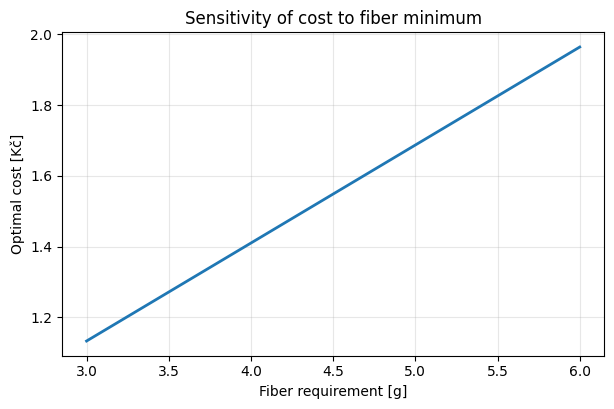

In [30]:
plt.figure(figsize=(7,4.2))
plt.plot(df_sweep["req_value"], df_sweep["cost_KC"], linewidth=2)
plt.xlabel("Fiber requirement [g]")
plt.ylabel("Optimal cost [Kč]")
plt.title("Sensitivity of cost to fiber minimum")
plt.grid(True, alpha=0.3)
plt.show()


### Graf: složení vs minimum vlákniny

Následující „stacked area“ ukazuje, jak se optimální mix mění při zpřísňování vlákniny.


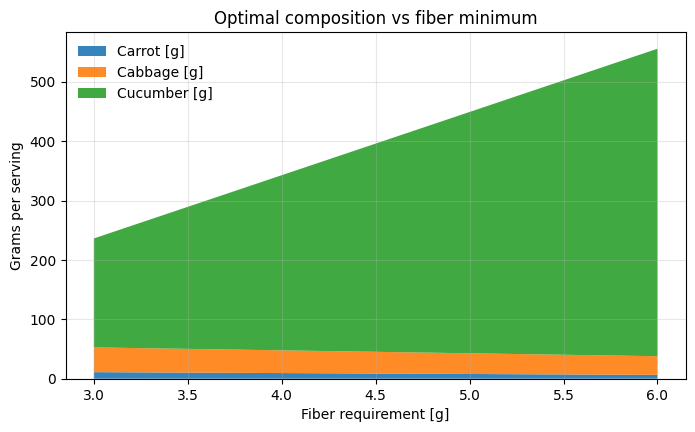

In [31]:
plt.figure(figsize=(8,4.5))
plt.stackplot(
    df_sweep["req_value"],
    df_sweep["x_carrot_g"], df_sweep["x_cabbage_g"], df_sweep["x_cucumber_g"],
    labels=["Carrot [g]","Cabbage [g]","Cucumber [g]"], alpha=0.9
)
plt.legend(loc="upper left", frameon=False)
plt.xlabel("Fiber requirement [g]")
plt.ylabel("Grams per serving")
plt.title("Optimal composition vs fiber minimum")
plt.grid(True, alpha=0.3)
plt.show()
